### First, this notebook creates a static version of the MODIS product to classify MTBS fires outside of the 2003-2016 MODIS data range. Then, it classifies all fires in MTBS. Finally, this notebook runs a time-varying fit on MTBS data in the USA and creates toy visualizations to show how the CCDF shape changes over time.

In [8]:
import os
import re
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
from collections import Counter
from scipy import stats
import pickle
import sys

sys.path.append("..")
from utils.temporal_analysis import *
from utils import wildfire_powerlaw as wfpl

First, build the static raster tiles (so that it can be applied to fires outside 2003-2016)

In [9]:
#REPLACE WITH FILEPATH TO ORIGINAL MTBS DATA
mtbs_gdf = load_shapefile(
    "/Users/lukevonkapff/wildfires/MTBS/S_USA.MTBS_BURN_AREA_BOUNDARY.shp",
    "EPSG:4269",
    area_col="AREA_SQKM"
)

mtbs_filtered = mtbs_gdf[mtbs_gdf["AREA_SQKM"] >= 4].copy()
mtbs_filtered = mtbs_filtered.rename(columns={"YEAR": "year", "AREA_SQKM": "area_km2"})

In [10]:
# REPLACE WITH PATH TO MODIS/GEOTIFF FOLDER (CREATED IN 3_LAND_COVER_CLASSIFICATION NOTEBOOK)
modis_folder = "/Users/lukevonkapff/wildfires/MODIS_USA/GeoTIFF"
modis_files = [os.path.join(modis_folder, f) for f in os.listdir(modis_folder) if f.endswith(".tif")]
modis_by_year = {}
for f in modis_files:
    match = re.search(r"A(\d{4})", os.path.basename(f))
    if match:
        year = int(match.group(1))
        modis_by_year.setdefault(year, []).append(f)

modis_to_gfa = {
    0: "Water",
    1: "Evergreen Needleleaf forest",
    2: "Evergreen Broadleaf forest",
    3: "Deciduous Needleleaf forest",
    4: "Deciduous Broadleaf forest",
    5: "Mixed forest",
    6: "Closed shrublands",
    7: "Open shrublands",
    8: "Woody savannas",
    9: "Savannas",
    10: "Grasslands",
    11: "Permanent wetlands",
    12: "Croplands",
    13: "Urban and built-up",
    14: "Cropland/Natural vegetation mosaic",
    15: "Snow and ice",
    16: "Barren or sparsely vegetated"
}

static_raster = build_static_modis_tiles(modis_by_year)

Use the static raster to classify all MTBS fires.

In [13]:
mtbs_classified = classify_with_modis(mtbs_filtered, "year", modis_by_year, modis_to_gfa)
mtbs_classified = classify_with_static(mtbs_classified, static_raster, modis_to_gfa)

output_path = "../data/mtbs_classified_static.shp"
mtbs_classified.to_file(output_path)
print(f"Saved GeoDataFrame to {output_path}")

Saved GeoDataFrame to ../data/mtbs_classified_static.shp


In [190]:
def classify_with_static_savanna_check(
    fires_gdf: gpd.GeoDataFrame,
    static_tile_dict: dict[str, str],
    modis_to_gfa: dict[int, str],
) -> gpd.GeoDataFrame:
    """Classify fire polygons using static (per-tile) MODIS rasters,
    except: if the majority class is 'Savannas' but ≤90% of area,
    assign the 2nd-most common class instead.

    Notes:
        - The static MODIS rasters are assumed to live under:
          /Users/lukevonkapff/Desktop/wildfires_github/wildfire_modeling/data/static_modis_tiles
    """
    base_dir = "/Users/lukevonkapff/Desktop/wildfires_github/wildfire_modeling/data/static_modis_tiles"
    results: list[tuple[int, str]] = []

    for tile_id, raster_path in static_tile_dict.items():
        # build full path
        raster_path_full = os.path.join(base_dir, os.path.basename(raster_path))

        try:
            with rasterio.open(raster_path_full) as src:
                fires_proj = fires_gdf.to_crs(src.crs)

                for idx, fire in fires_proj.iterrows():
                    try:
                        out_image, _ = rasterio.mask.mask(src, [fire.geometry], crop=True)
                    except ValueError:
                        continue

                    data = out_image[0]
                    data = data[(data != src.nodata) & (data != 255)]
                    if data.size == 0:
                        continue

                    # Map MODIS numeric codes → GFA class names
                    mapped = [modis_to_gfa.get(int(val), "Other") for val in data]

                    counts = Counter(mapped)
                    total = sum(counts.values())
                    if total == 0:
                        continue

                    ordered = counts.most_common()
                    top_class, top_count = ordered[0]
                    top_frac = top_count / total

                    # Savanna override logic
                    if top_class == "Savannas" and top_frac <= 0.9 and len(ordered) > 1:
                        alt_class = ordered[1][0]
                        results.append((idx, alt_class))
                    else:
                        results.append((idx, top_class))
        except rasterio.errors.RasterioIOError:
            print(f"⚠️ Skipping missing tile {tile_id}: {raster_path_full}")
            continue

    fires_out = fires_gdf.copy()
    fires_out["modis_class_static_no_savanna"] = "Unknown"
    for idx, cls in results:
        fires_out.at[idx, "modis_class_static_no_savanna"] = cls

    return fires_out

mtbs_classified = classify_with_static_savanna_check(mtbs_classified, static_raster, modis_to_gfa)

Evaluate how well new static raster mapping matches original time-varying raster.

In [195]:
overlap_mask = (mtbs_classified["year"].between(2003, 2016)) & \
               (mtbs_classified["modis_class_timevary"] != "Unknown")

comparison_df = mtbs_classified.loc[overlap_mask].copy()
comparison_df["match"] = (
    comparison_df["modis_class_timevary"] == comparison_df["modis_class_static"]
)

agreement_rate = comparison_df["match"].mean()
print(f"Agreement between time-varying and static MODIS classifications (2003–2016): {agreement_rate:.2%}")
print(comparison_df[["year", "area_km2", "modis_class_timevary", "modis_class_static", "match"]].head())

Agreement between time-varying and static MODIS classifications (2003–2016): 89.68%
      year   area_km2 modis_class_timevary modis_class_static  match
4793  2003  22.834762       Woody savannas     Woody savannas   True
4794  2003   8.722727      Open shrublands         Grasslands  False
4795  2003  13.418604           Grasslands         Grasslands   True
4796  2003   5.596480           Grasslands         Grasslands   True
4797  2003   9.250212           Grasslands         Grasslands   True


## 2 visualizations to justify keeping xmin = 4 cutoff...

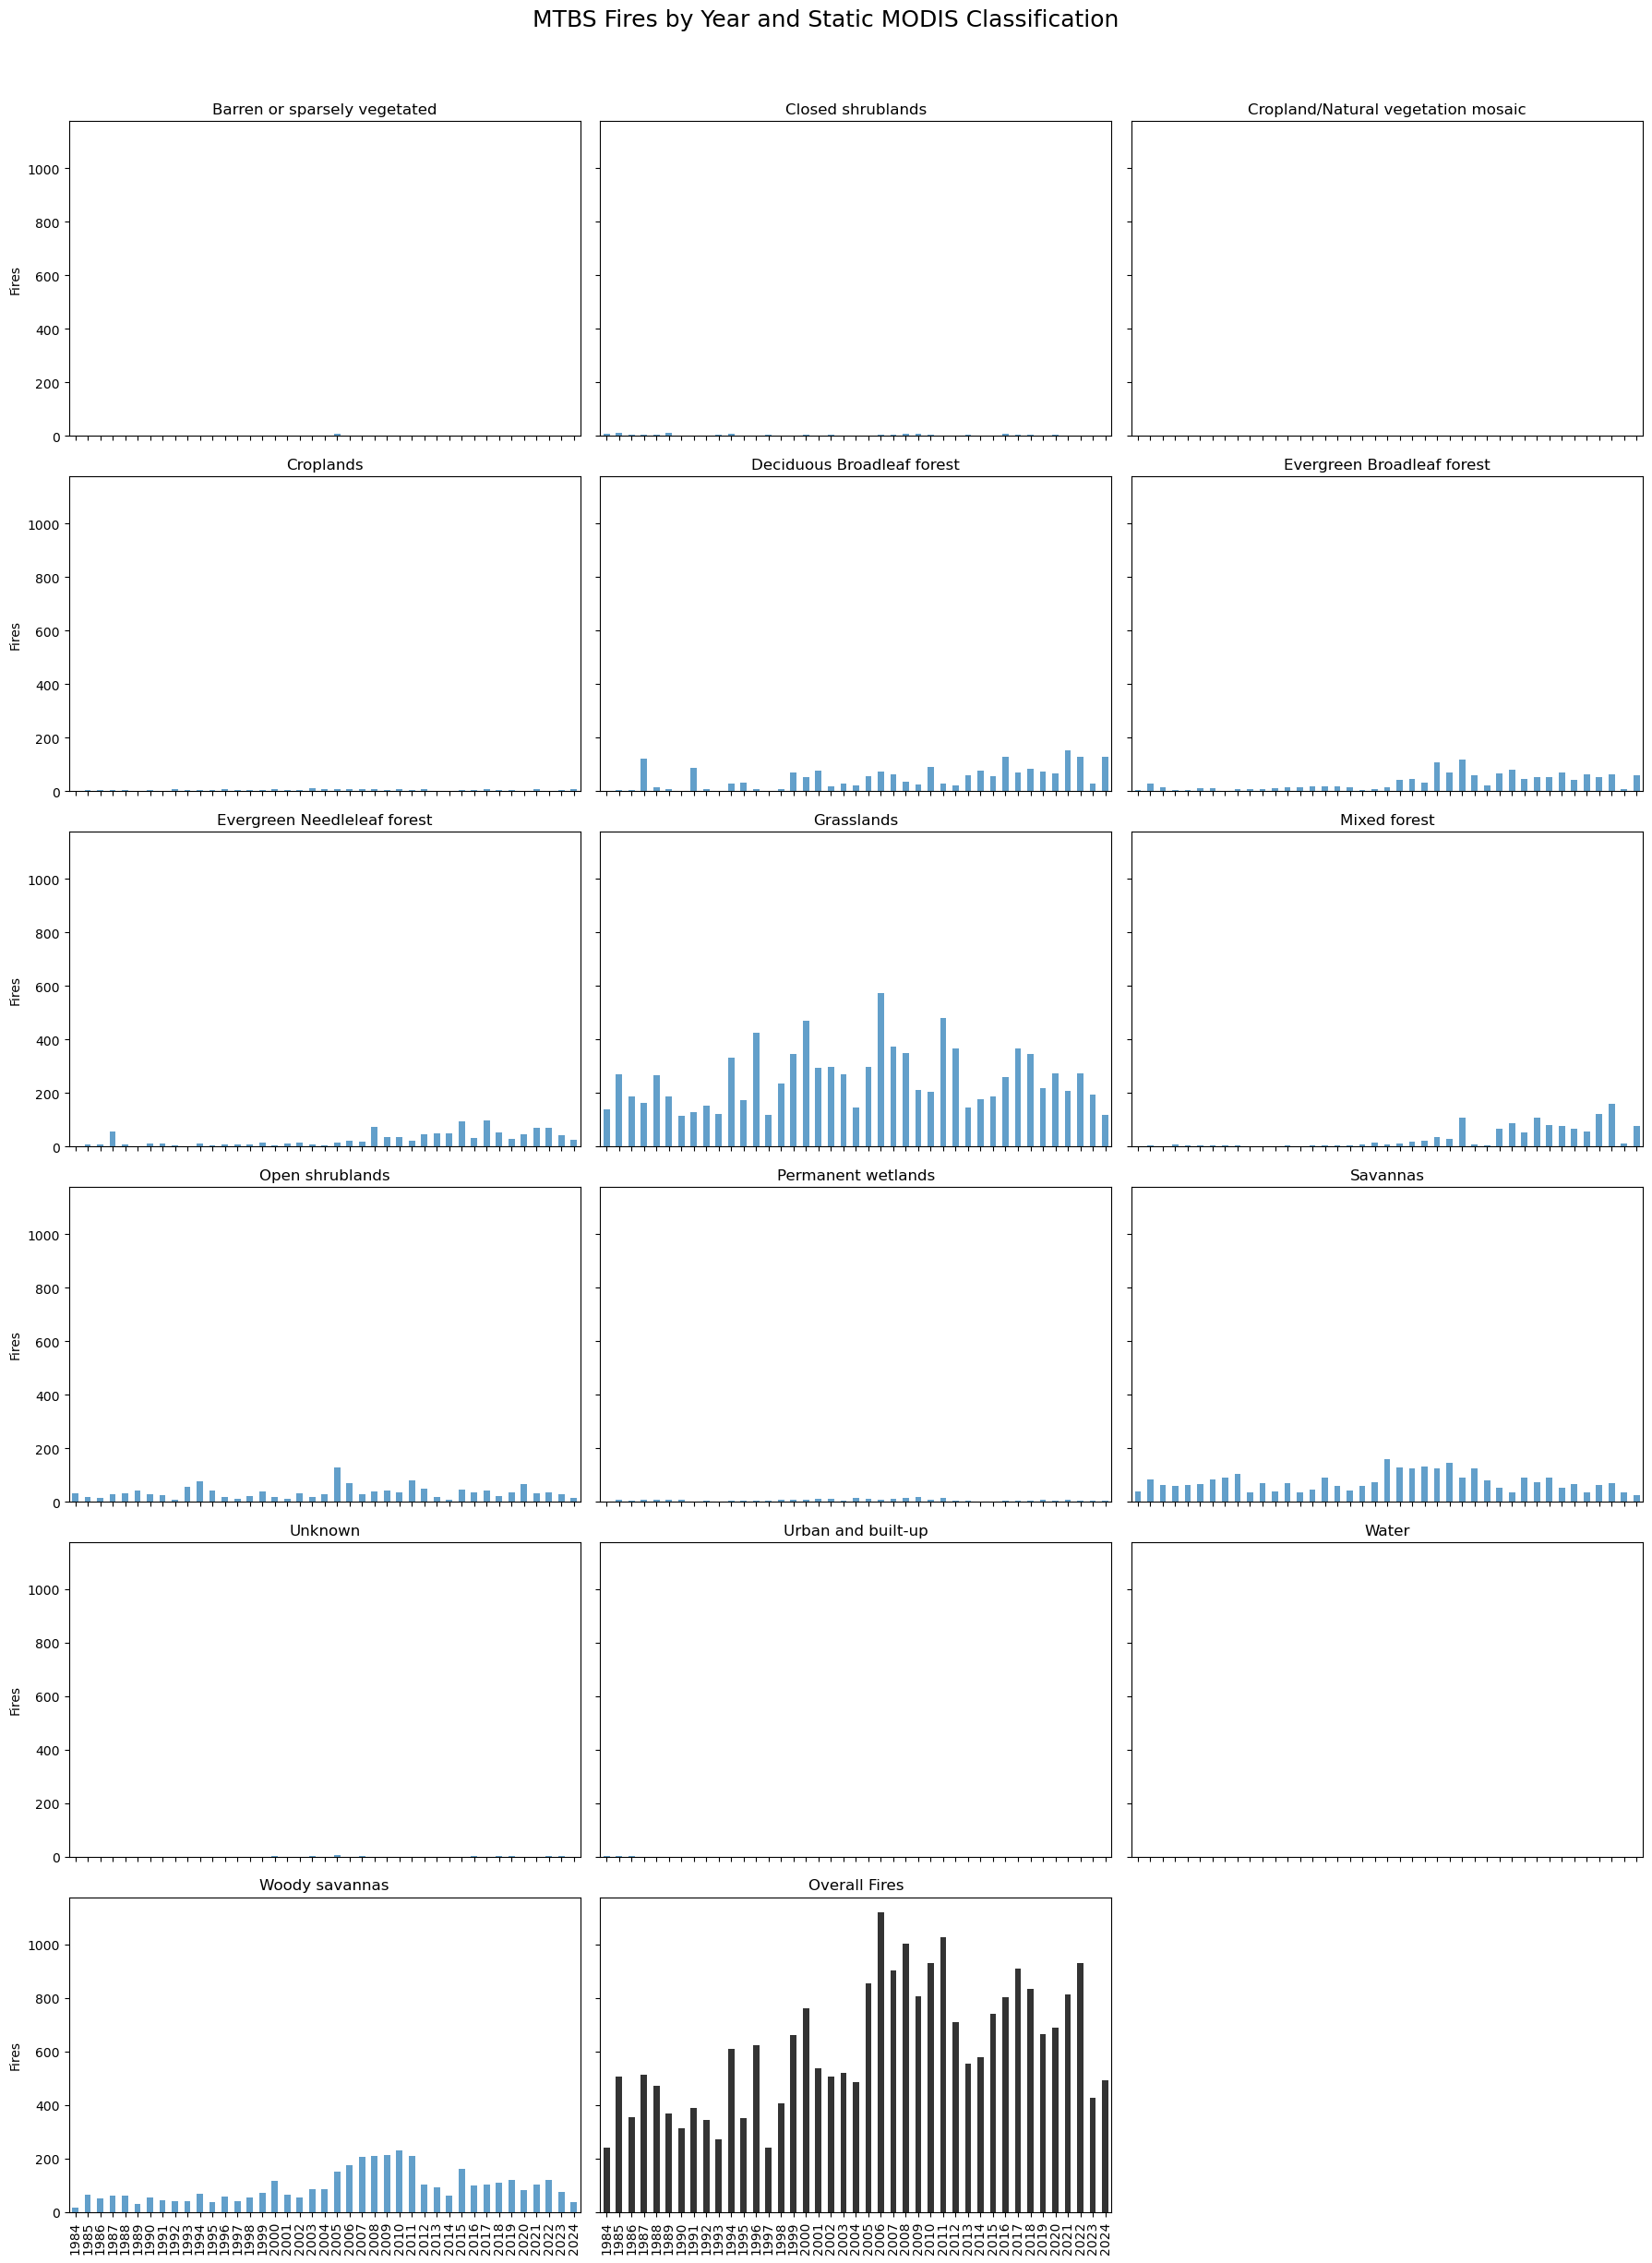

In [19]:
plot_fire_counts_faceted(mtbs_classified)

✅ Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/fires_time_series.png


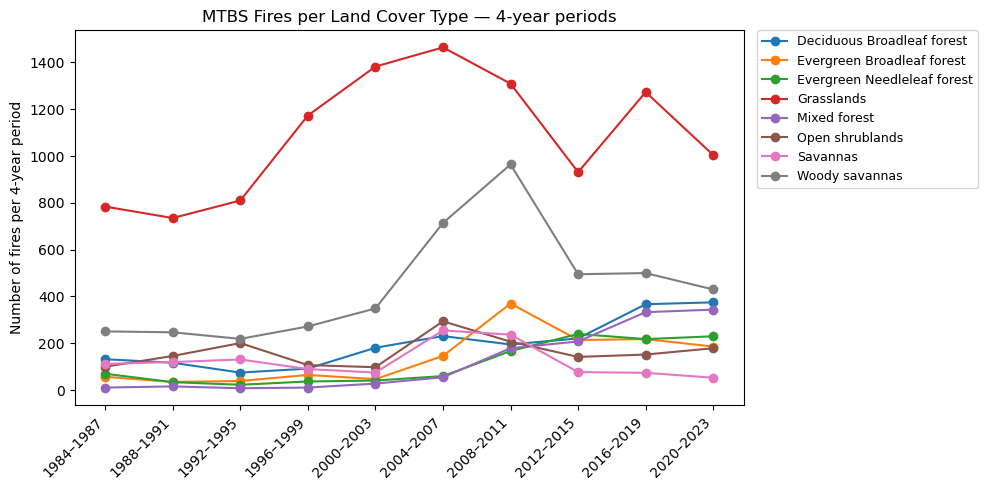

In [193]:
counts_long, counts_wide = fires_time_series_by_ecoregion(
    mtbs_classified,
    year_col="year",
    class_col="modis_class_static",
    period_years=4,
    include_total=False,   # optional
    plot=True
)

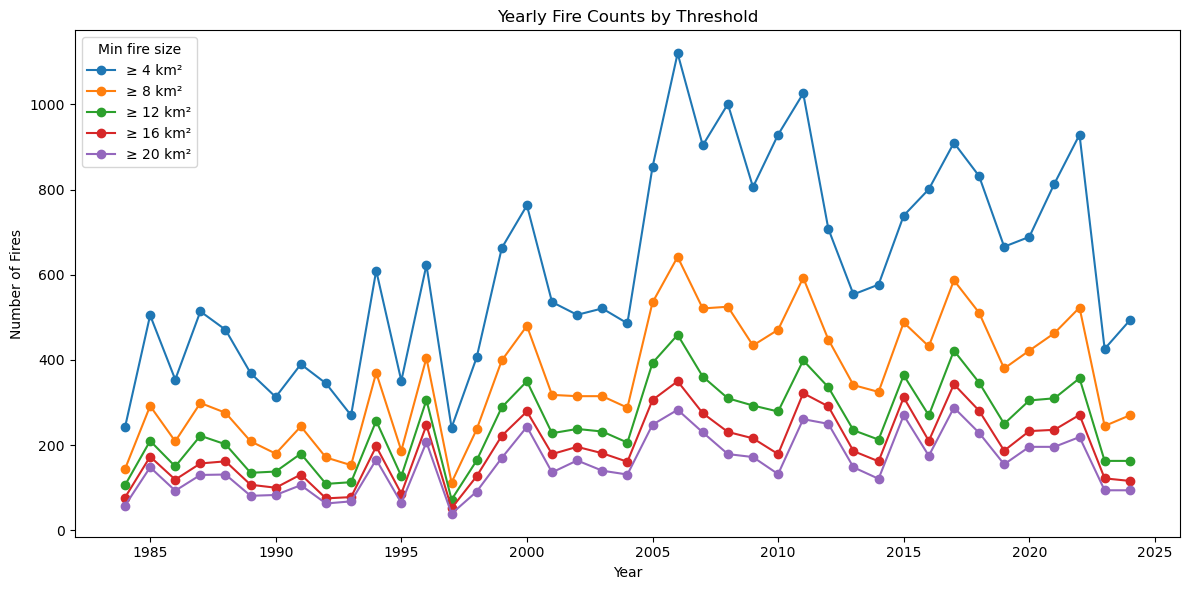

In [20]:
fire_threshold_analysis(mtbs_classified,
                                year_col="year",
                                area_col="area_km2",
                                thresholds=[4, 8, 12, 16, 20])

Thus, there is no other min fire size threshold that will eliminate large jumps in fire size after a certain year, meaning we can stick with 4km2. Now, let's run the fitting routine on each biome using the new land cover classification.

In [22]:
# This cell takes a long time to run -- the overall_results output is in data folder

overall_results = {}

for modis_cat, subset in mtbs_classified.groupby("modis_class_static"):
    data = subset["area_km2"].values
    
    if len(data) == 0:
        continue
    
    print(f"\n=== {modis_cat} (n={len(data)}) ===")
    
    params = wfpl.summarize_parameters_bootstrap(
        data, R=50, xmin=4, random_state=42
    )
    R, best = wfpl.likelihood_matrix_and_best(
        data, xmin=4
    )
    
    overall_results[modis_cat] = {
        "params": params,
        "likelihood_matrix": R,
        "best_fit": best
    }

save_path = "../data/mtbs_static_fits_by_biome.pkl"
with open(save_path, "wb") as f:
    pickle.dump(overall_results, f)

print(f"Saved overall_results to: {save_path}")


=== Barren or sparsely vegetated (n=10) ===
there are 10 points above xmin 4.0 km^2

=== Closed shrublands (n=159) ===
there are 159 points above xmin 4.0 km^2

=== Cropland/Natural vegetation mosaic (n=2) ===
there are 2 points above xmin 4.0 km^2

=== Croplands (n=208) ===
there are 208 points above xmin 4.0 km^2

=== Deciduous Broadleaf forest (n=2041) ===
there are 2041 points above xmin 4.0 km^2

=== Evergreen Broadleaf forest (n=1388) ===
there are 1388 points above xmin 4.0 km^2

=== Evergreen Needleleaf forest (n=1111) ===
there are 1111 points above xmin 4.0 km^2

=== Grasslands (n=10438) ===
there are 10438 points above xmin 4.0 km^2

=== Mixed forest (n=1268) ===
there are 1268 points above xmin 4.0 km^2

=== Open shrublands (n=1433) ===
there are 1433 points above xmin 4.0 km^2

=== Permanent wetlands (n=238) ===
there are 238 points above xmin 4.0 km^2

=== Savannas (n=3044) ===
there are 3044 points above xmin 4.0 km^2

=== Unknown (n=34) ===
there are 34 points above xm

And now, we run the time-varying version of the fitting routine where each parameter is written as p1+p2*t (with modification for truncated power law, see utils). 

In [26]:
timevary_results = analyze_time_varying_mle(mtbs_classified, overall_results, xmin = 4, R_boot = 50)
df_both = summarize_timevary_results_mode(timevary_results, mode="both")


save_path_time_varying = "../data/mtbs_time_varying_fits_by_biome.pkl"
with open(save_path_time_varying, "wb") as f:
    pickle.dump(timevary_results, f)

print(f"Saved overall_results to: {save_path_time_varying}")


=== Barren or sparsely vegetated skipped: only 10 fires above xmin (4) ===

=== Closed shrublands skipped: only 159 fires above xmin (4) ===

=== Cropland/Natural vegetation mosaic skipped: only 2 fires above xmin (4) ===

=== Croplands skipped: only 208 fires above xmin (4) ===

=== Deciduous Broadleaf forest (n=2041 fires ≥ 4) ===

=== Evergreen Broadleaf forest (n=1388 fires ≥ 4) ===

=== Evergreen Needleleaf forest (n=1111 fires ≥ 4) ===

=== Grasslands (n=10438 fires ≥ 4) ===

=== Mixed forest (n=1268 fires ≥ 4) ===

=== Open shrublands (n=1433 fires ≥ 4) ===

=== Permanent wetlands skipped: only 238 fires above xmin (4) ===

=== Savannas (n=3044 fires ≥ 4) ===

=== Unknown skipped: only 34 fires above xmin (4) ===

=== Urban and built-up skipped: only 16 fires above xmin (4) ===

=== Water skipped: only 1 fires above xmin (4) ===

=== Woody savannas (n=3865 fires ≥ 4) ===
Saved overall_results to: ../data/mtbs_time_varying_fits_by_biome.pkl


Now, to view the results from the time-varying fits...

In [53]:
df_both = summarize_timevary_results_mode(timevary_results, mode="both")
df_p1 = summarize_timevary_results_mode(timevary_results, mode="p1_only")
df_p2 = summarize_timevary_results_mode(timevary_results, mode="p2_only")
df_both

,biome,distribution,n,p1,p1_se,p1',p1'_se,p2,p2_se,p2',p2'_se,p1_slope_sig,p2_slope_sig
0,Deciduous Broadleaf forest,generalized_pareto,2041,0.470531,5.882589e-02,-0.086010,0.048334,4.669513,2.669932e-01,-0.809641,0.211527,0,1
1,Evergreen Broadleaf forest,generalized_pareto,1388,0.408186,6.275691e-02,-0.164975,0.057368,5.071971,3.293930e-01,0.318179,0.275185,1,0
2,Evergreen Needleleaf forest,lognormal,1111,2.804982,7.342493e-02,0.099899,0.069931,1.186876,7.299636e-02,0.100074,0.062230,0,0
3,Evergreen Needleleaf forest,stretched_exponential,1111,26.265964,1.025356e+01,-0.168502,0.533259,0.207096,1.161735e-02,-0.012629,0.003860,0,1
4,Evergreen Needleleaf forest,truncated_power_law,1111,1.560384,3.594106e-16,-0.176678,0.287779,0.000787,2.168404e-19,0.000655,0.000448,0,0
5,Evergreen Needleleaf forest,weibull,1111,0.694156,2.485206e-02,-0.059793,0.023921,32.045860,2.888891e+00,4.044019,1.716100,1,1
6,Grasslands,lognormal,10438,2.719330,5.399728e-02,0.048189,0.050525,1.096842,3.212381e-02,0.052059,0.036271,0,0
7,Grasslands,stretched_exponential,10438,12.333152,1.206149e+01,-0.358208,0.527522,0.229822,1.105827e-02,-0.004910,0.001843,0,1
8,Grasslands,weibull,10438,0.729872,2.379182e-02,-0.037011,0.020048,27.753393,1.687791e+00,2.092591,1.410271,0,0
9,Mixed forest,generalized_pareto,1268,0.426512,8.396930e-02,-0.224249,0.073964,2.924505,3.219464e-01,0.674780,0.246461,1,1


Or just the "main" ones...

In [63]:
summary_table = summarize_ecoregion_fits(df_both, df_p1, df_p2, overall_results)
summary_table

,biome,distribution,n,Δloglik,p1 ± se,p2 ± se,Δp1 ± se,Δp2 ± se
0,Deciduous Broadleaf forest,generalized_pareto,2041,0.000000,0.471 ± 0.059,4.670 ± 0.267,,-0.810 ± 0.212
1,Evergreen Broadleaf forest,generalized_pareto,1388,0.000000,0.408 ± 0.063,5.072 ± 0.329,-0.165 ± 0.057,
2,Mixed forest,generalized_pareto,1268,0.000000,0.427 ± 0.084,2.925 ± 0.322,-0.224 ± 0.074,
3,Savannas,truncated_power_law,3044,0.000000,1.842 ± 0.000,0.000 ± 0.000,,
4,Woody savannas,truncated_power_law,3865,0.000000,1.810 ± 0.000,0.000 ± 0.000,,
5,Evergreen Needleleaf forest,lognormal,1111,1.403200,2.805 ± 0.073,1.187 ± 0.073,,
6,Grasslands,lognormal,10438,0.000000,2.719 ± 0.054,1.097 ± 0.032,,
7,Open shrublands,lognormal,1433,0.707255,2.910 ± 0.065,1.202 ± 0.059,0.124 ± 0.059,


And just the additional fits...

In [64]:
summary_other = summarize_other_fits(df_both, df_p1, df_p2, overall_results)
summary_other

,biome,distribution,n,Δloglik,p1 ± se,p2 ± se,Δp1 ± se,Δp2 ± se
0,Evergreen Needleleaf forest,stretched_exponential,1111,8.135237e-01,26.266 ± 10.254,0.207 ± 0.012,,-0.013 ± 0.004
1,Evergreen Needleleaf forest,truncated_power_law,1111,0.000000e+00,1.560 ± 0.000,0.001 ± 0.000,,
2,Evergreen Needleleaf forest,weibull,1111,8.135274e-01,0.694 ± 0.025,32.046 ± 2.889,-0.060 ± 0.024,4.044 ± 1.716
3,Grasslands,stretched_exponential,10438,1.834964e+00,12.333 ± 12.061,0.230 ± 0.011,,-0.005 ± 0.002
4,Grasslands,weibull,10438,1.834966e+00,0.730 ± 0.024,27.753 ± 1.688,,
5,Mixed forest,lognormal,1268,1.841576e+00,1.996 ± 0.035,0.530 ± 0.032,,
6,Open shrublands,stretched_exponential,1433,0.000000e+00,18.064 ± 10.294,0.207 ± 0.014,,-0.008 ± 0.002
7,Open shrublands,weibull,1433,9.781070e-08,0.695 ± 0.031,35.696 ± 2.727,,6.500 ± 1.408


To visualize where fires in each grouping occur:

✅ Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/fire_locations.png


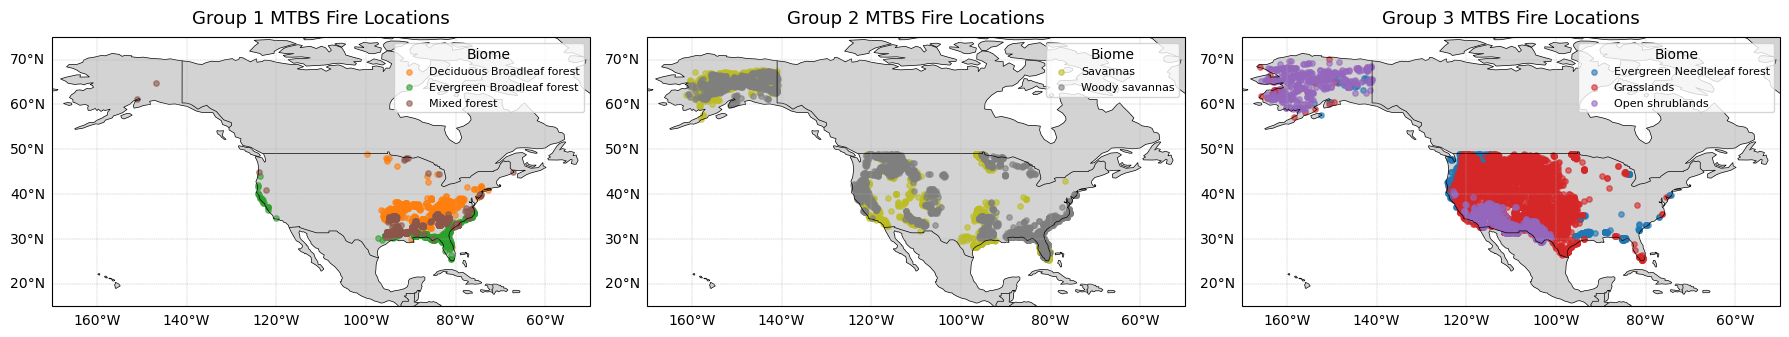

In [36]:
plot_biome_facets(mtbs_classified)

The following function runs a Poisson regression on each land cover type and is used to determine if change in tail shape is due to relative change in either small or large fires (or both).

✅ Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/poisson_trends.png


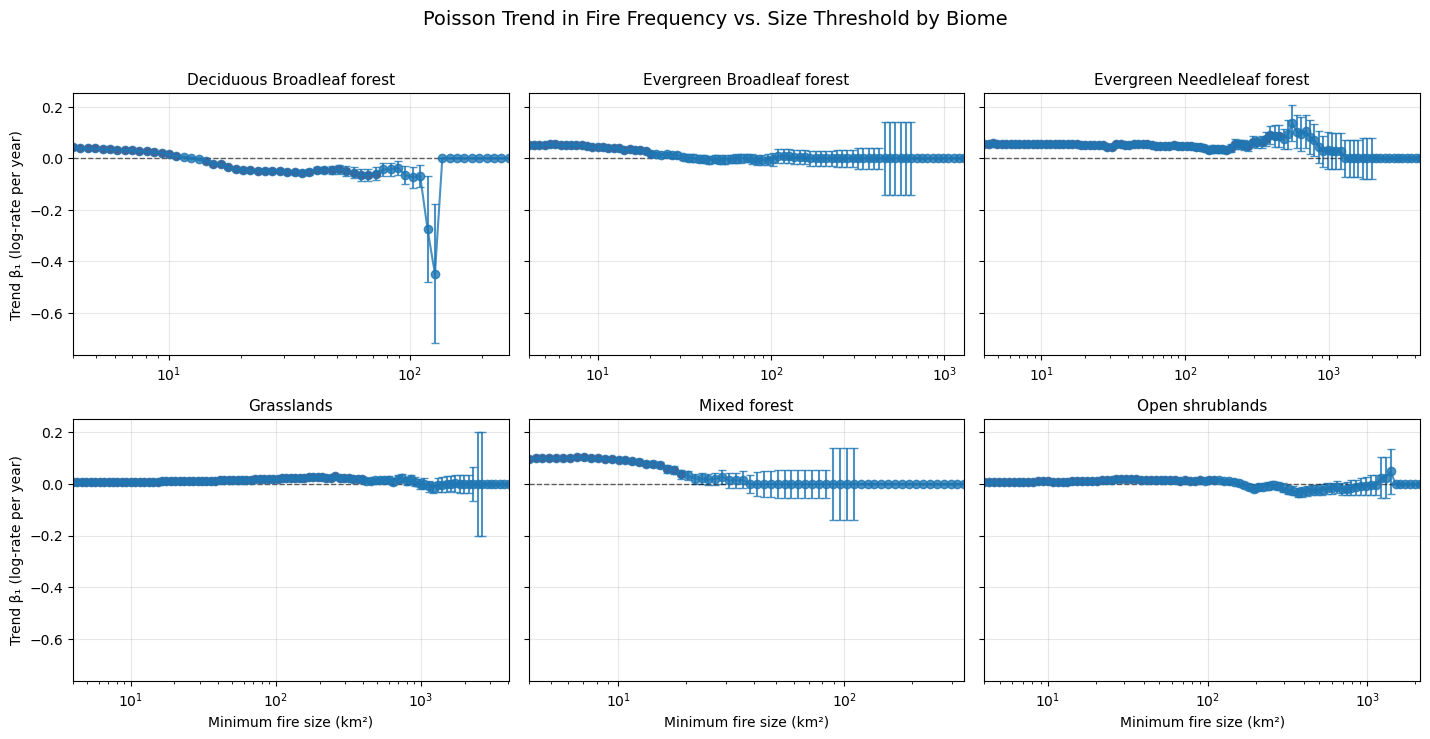

,biome,Amin_km2,beta1,beta1_se,pval,n_years
0,Deciduous Broadleaf forest,4.000000,0.043803,0.002021,3.273936e-104,41
1,Deciduous Broadleaf forest,4.292457,0.039900,0.002111,1.148564e-79,39
2,Deciduous Broadleaf forest,4.606297,0.038791,0.002185,1.641980e-70,39
3,Deciduous Broadleaf forest,4.943083,0.038069,0.002266,2.428947e-63,39
4,Deciduous Broadleaf forest,5.304493,0.036023,0.002347,3.788893e-53,39
...,...,...,...,...,...,...
491,Open shrublands,1610.525239,0.000000,0.000000,NaN,1
492,Open shrublands,1728.277620,0.000000,0.000000,NaN,1
493,Open shrublands,1854.639382,0.000000,0.000000,NaN,1
494,Open shrublands,1990.239991,0.000000,0.000000,NaN,1


In [71]:
poisson_by_biome = fit_poisson_tail_trend_by_biome_highres(mtbs_classified)
poisson_by_biome


✅ Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/mixed_forest_cdf_ccdf_qq.png


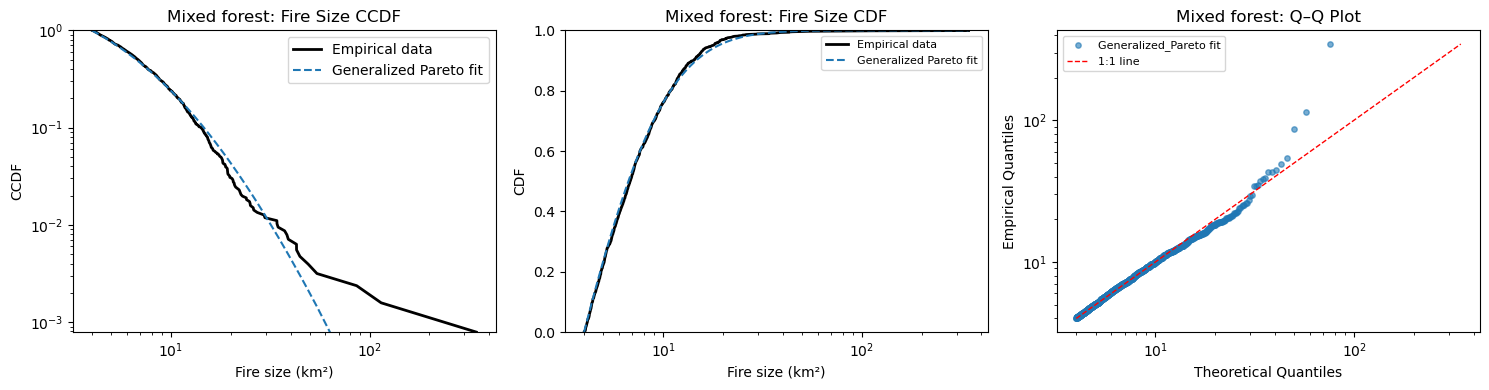

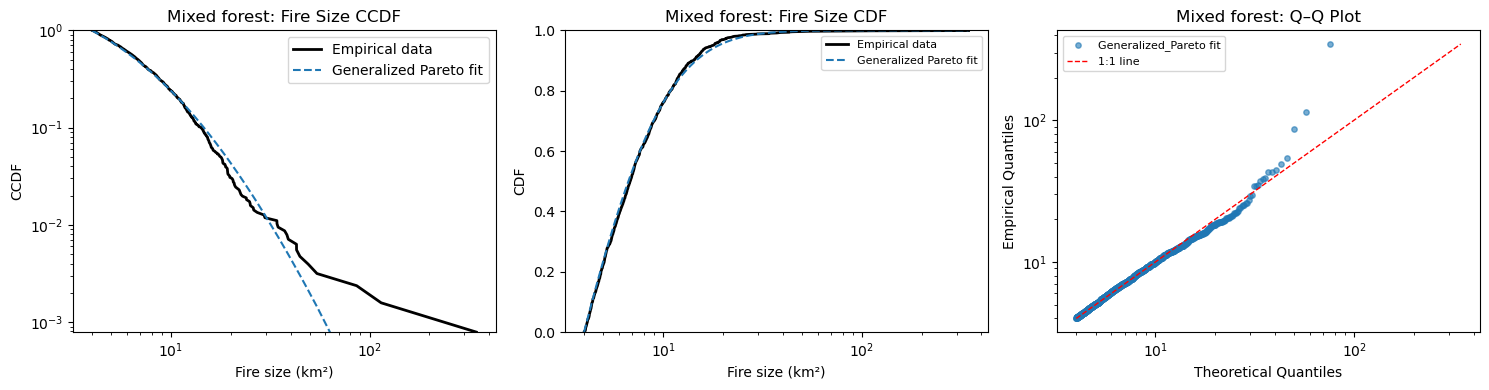

In [187]:
plot_modis_category_ccdf_cdf_qq(mtbs_classified, "Mixed forest", which = ["generalized_pareto"])

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/deciduous broadleaf forest_generalized_pareto_over_time.png


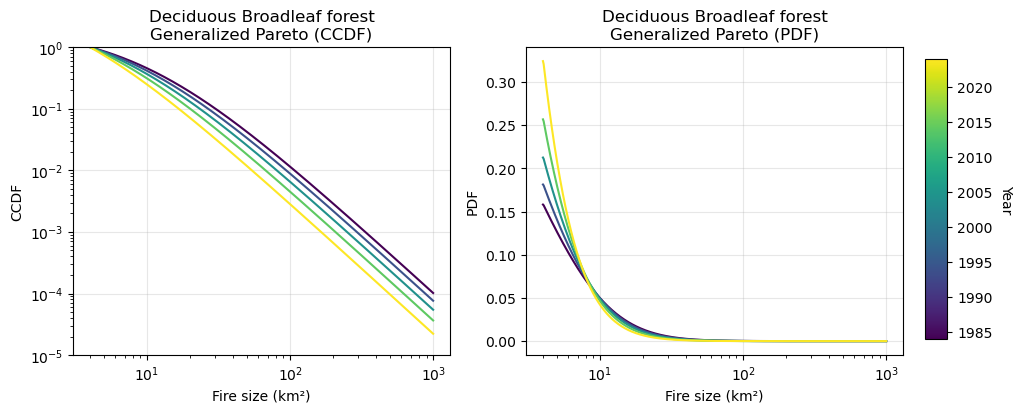

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/evergreen broadleaf forest_generalized_pareto_over_time.png


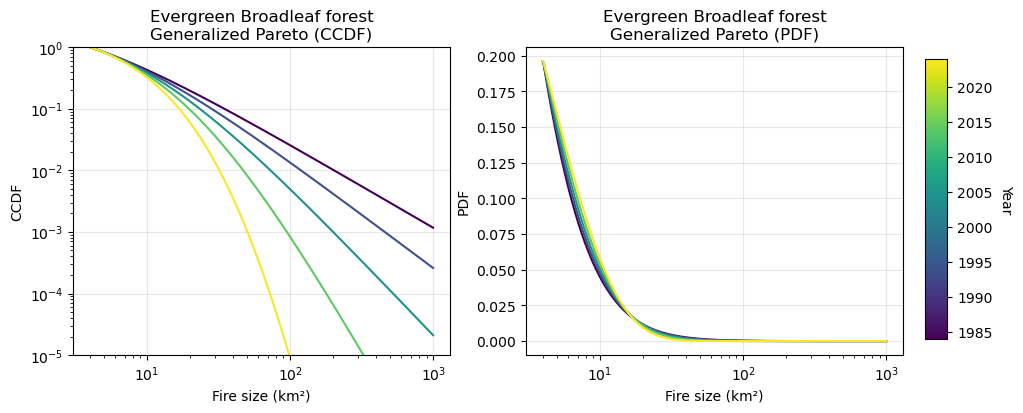

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/evergreen needleleaf forest_lognormal_over_time.png


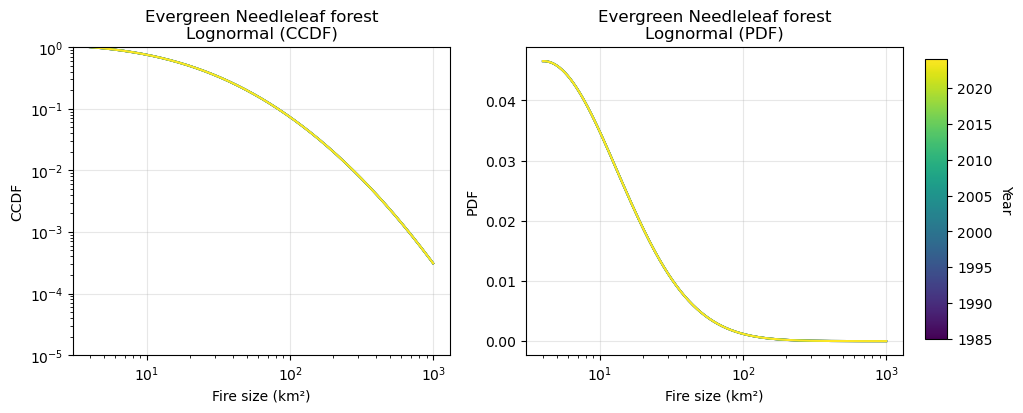

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/evergreen needleleaf forest_stretched_exponential_over_time.png


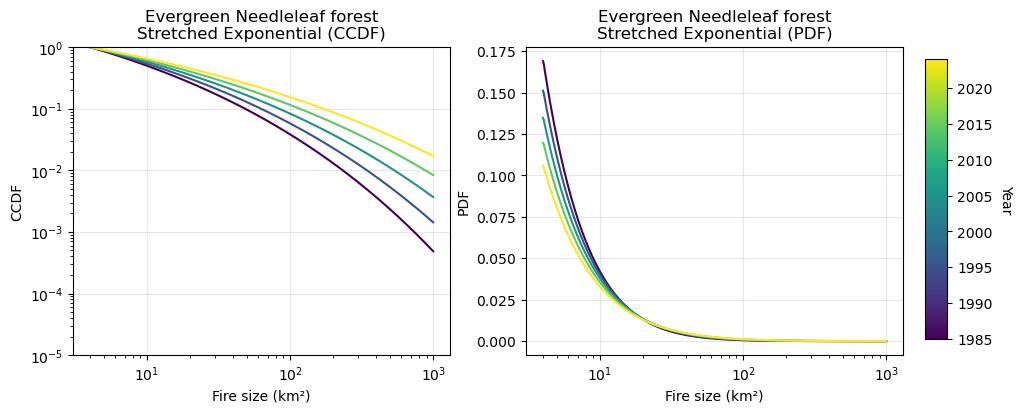

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/evergreen needleleaf forest_truncated_power_law_over_time.png


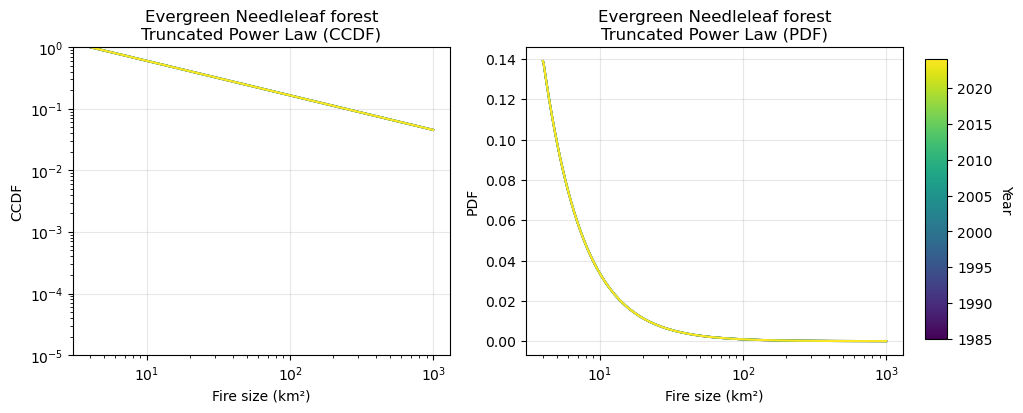

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/evergreen needleleaf forest_weibull_over_time.png


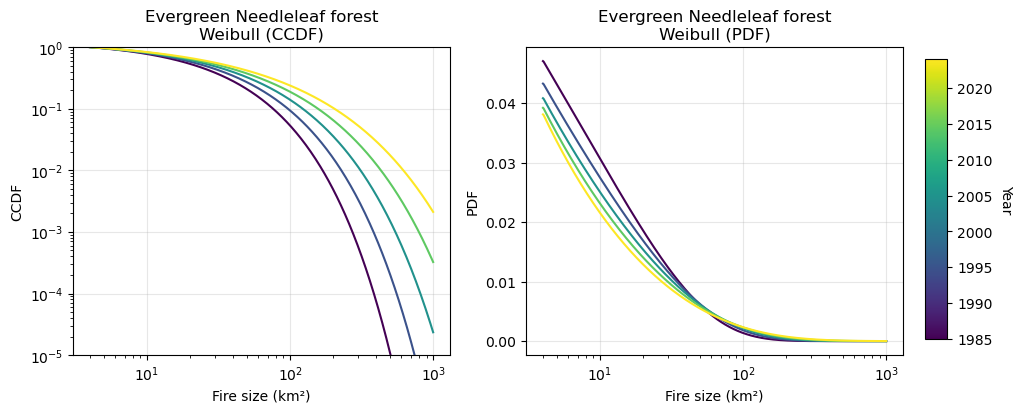

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/grasslands_lognormal_over_time.png


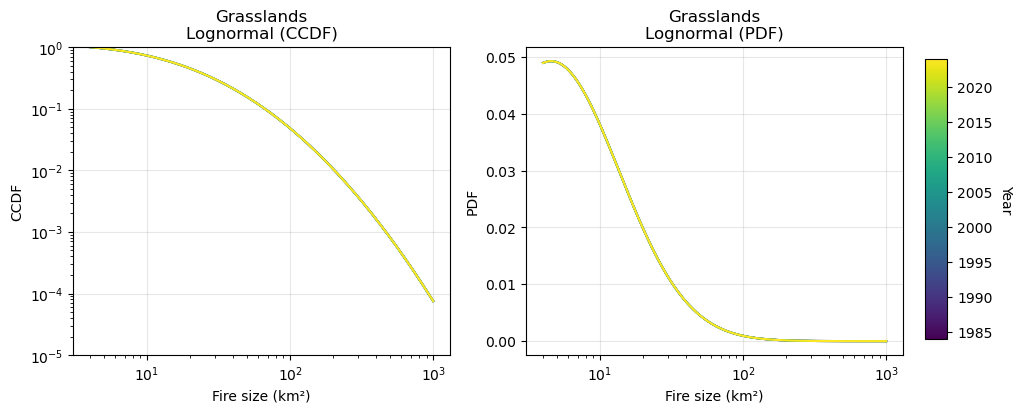

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/grasslands_stretched_exponential_over_time.png


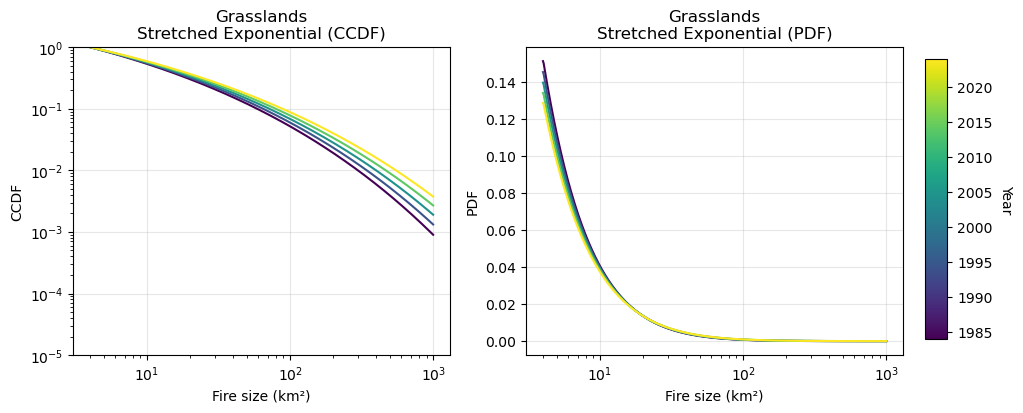

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/grasslands_weibull_over_time.png


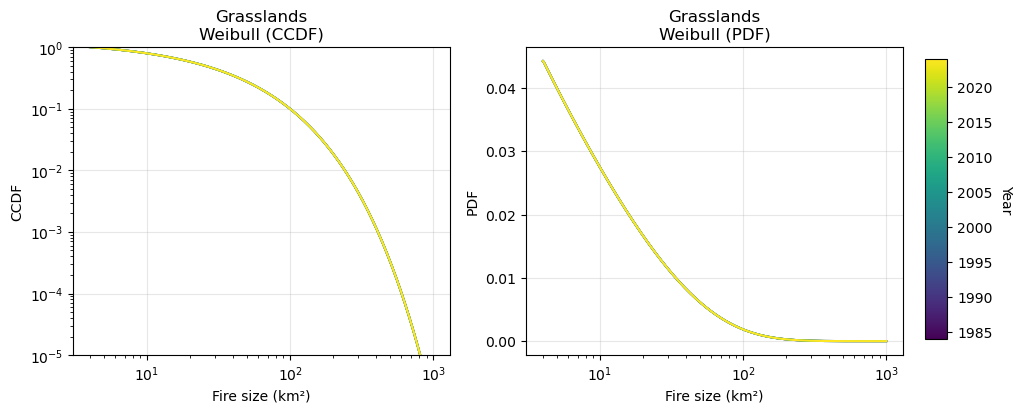

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/mixed forest_generalized_pareto_over_time.png


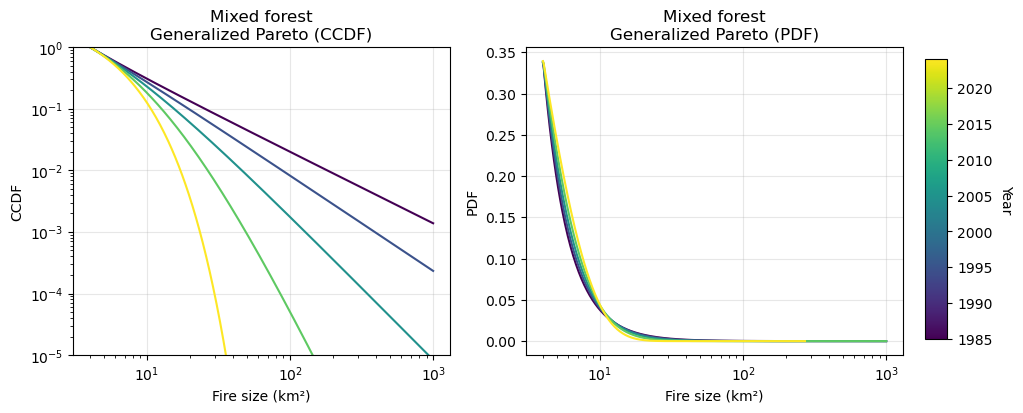

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/mixed forest_lognormal_over_time.png


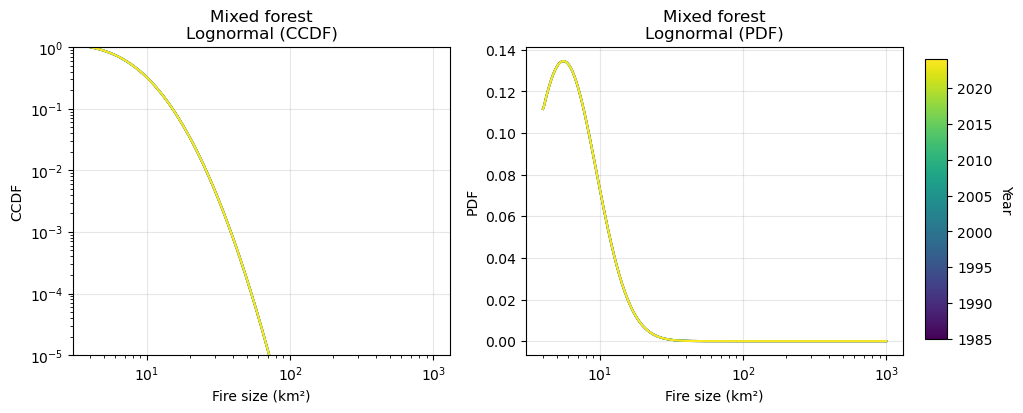

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/open shrublands_lognormal_over_time.png


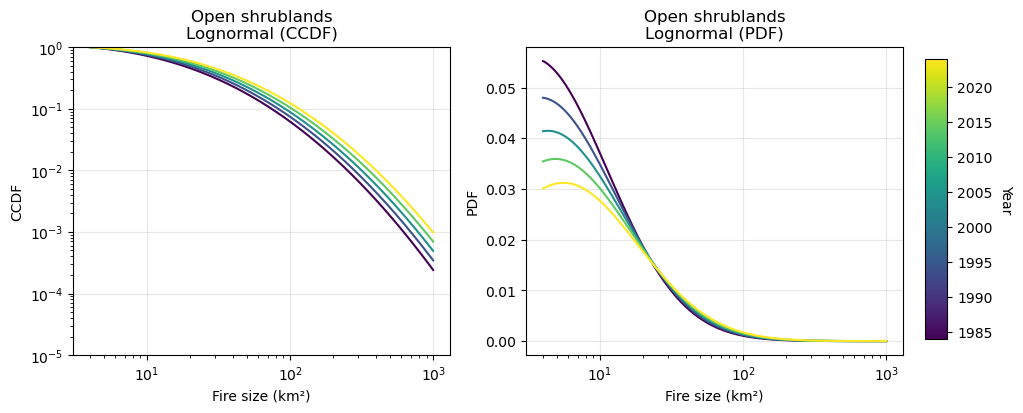

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/open shrublands_stretched_exponential_over_time.png


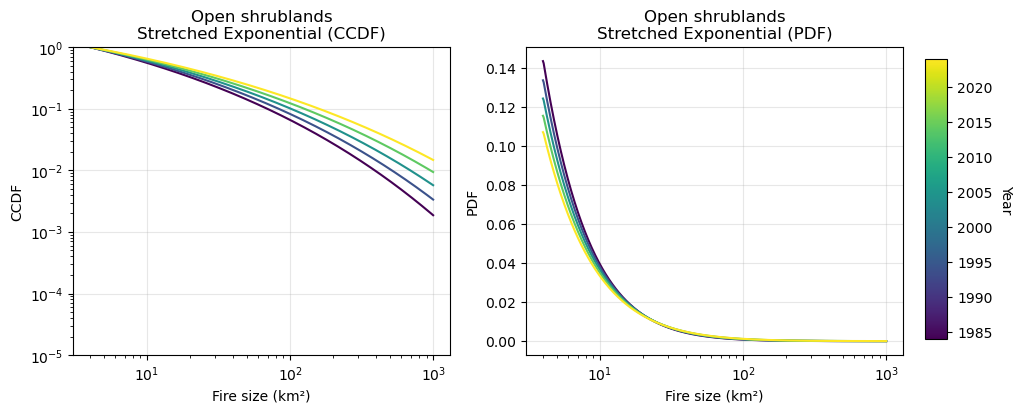

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/open shrublands_weibull_over_time.png


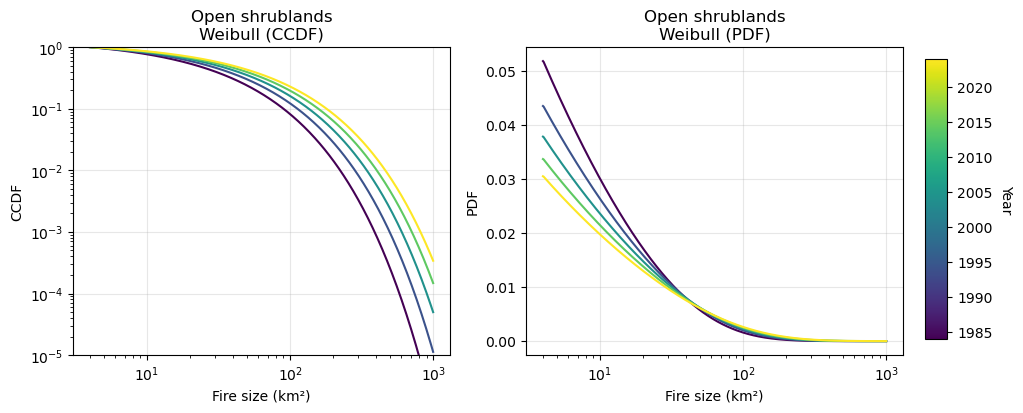

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/savannas_truncated_power_law_over_time.png


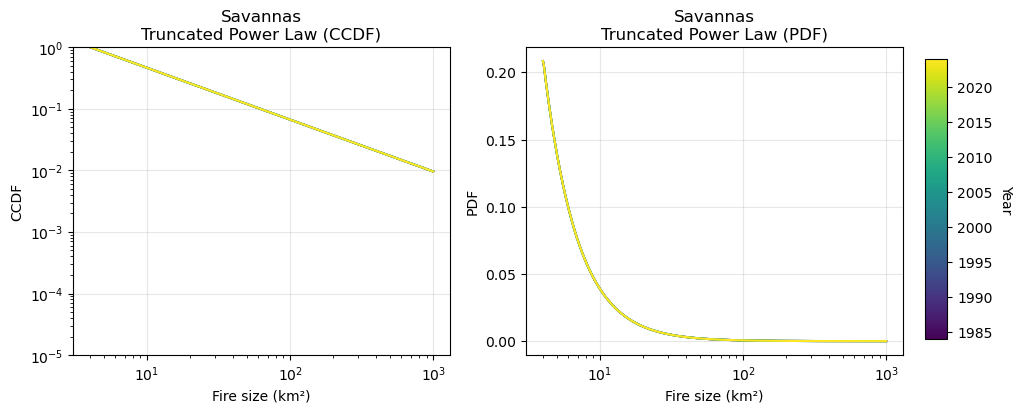

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/woody savannas_truncated_power_law_over_time.png


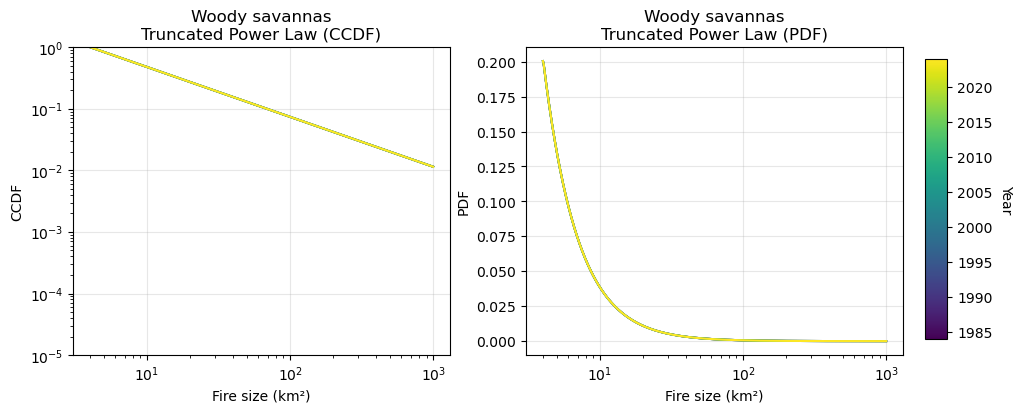

In [172]:
plot_distribution_evolution_ccdf_pdf(
    df_both,
    mtbs_classified,
    df_p1=df_p1,
    df_p2=df_p2,
    xmin=4
)

In [196]:
# This cell takes a long time to run -- the overall_results output is in data folder

overall_results_no_savanna = {}

for modis_cat, subset in mtbs_classified.groupby("modis_class_static_no_savanna"):
    data = subset["area_km2"].values
    
    if len(data) == 0:
        continue
    
    print(f"\n=== {modis_cat} (n={len(data)}) ===")
    
    params = wfpl.summarize_parameters_bootstrap(
        data, R=50, xmin=4, random_state=42
    )
    R, best = wfpl.likelihood_matrix_and_best(
        data, xmin=4
    )
    
    overall_results_no_savanna[modis_cat] = {
        "params": params,
        "likelihood_matrix": R,
        "best_fit": best
    }

save_path = "../data/mtbs_static_fits_by_biome_no_savanna.pkl"
with open(save_path, "wb") as f:
    pickle.dump(overall_results_no_savanna, f)

print(f"Saved overall_results to: {save_path}")


=== Barren or sparsely vegetated (n=10) ===
there are 10 points above xmin 4.0 km^2

=== Closed shrublands (n=202) ===
there are 202 points above xmin 4.0 km^2

=== Cropland/Natural vegetation mosaic (n=11) ===
there are 11 points above xmin 4.0 km^2

=== Croplands (n=222) ===
there are 222 points above xmin 4.0 km^2

=== Deciduous Broadleaf forest (n=2117) ===
there are 2117 points above xmin 4.0 km^2

=== Evergreen Broadleaf forest (n=1436) ===
there are 1436 points above xmin 4.0 km^2

=== Evergreen Needleleaf forest (n=1146) ===
there are 1146 points above xmin 4.0 km^2

=== Grasslands (n=10987) ===
there are 10987 points above xmin 4.0 km^2

=== Mixed forest (n=1268) ===
there are 1268 points above xmin 4.0 km^2

=== Open shrublands (n=1640) ===
there are 1640 points above xmin 4.0 km^2

=== Permanent wetlands (n=435) ===
there are 435 points above xmin 4.0 km^2

=== Savannas (n=1235) ===
there are 1235 points above xmin 4.0 km^2

=== Unknown (n=34) ===
there are 34 points above 

In [197]:
overall_results_no_savanna

{'Barren or sparsely vegetated': {'params':                              p1         p1_se         p2      p2_se  \
  distribution                                                          
  exponential            0.042662  2.800289e-02        NaN        NaN   
  generalized_pareto     0.655554  2.524211e+02  10.973111  10.723180   
  lognormal              1.881529  3.027697e+02   1.496101   7.881990   
  lognormal_excess       2.184704  4.444607e-01   1.516855   0.229648   
  power_law              1.718093  1.855124e-01        NaN        NaN   
  stretched_exponential  0.198406  8.145317e+07   0.457604   0.376671   
  truncated_power_law    1.114416  3.279300e-01   0.012340   0.015211   
  weibull                0.457614  3.791041e-01   5.039894  10.591283   
  weibull_excess         0.725158  1.690587e-01  18.847780   8.162488   
  
                          reduces_to  
  distribution                        
  exponential                    NaN  
  generalized_pareto     exponentia

In [200]:
mtbs_classified['modis_class_static_no_savanna'].value_counts()

modis_class_static_no_savanna
Grasslands                            10987
Woody savannas                         4483
Deciduous Broadleaf forest             2117
Open shrublands                        1640
Evergreen Broadleaf forest             1436
Mixed forest                           1268
Savannas                               1235
Evergreen Needleleaf forest            1146
Permanent wetlands                      435
Croplands                               222
Closed shrublands                       202
Unknown                                  34
Urban and built-up                       24
Cropland/Natural vegetation mosaic       11
Barren or sparsely vegetated             10
Water                                     6
Name: count, dtype: int64